# Lumen Data Science

PyTissue

Update or install important libraries

In [193]:
if False:
    !pip install -Uqq fastai
    !pip install -Uqq librosa

In [194]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
from IPython.display import Audio
from IPython.utils import io
import re
import itertools
import matplotlib.pyplot as plot
sys.path.append('../')

## Label getters

In [195]:
train_path = Path("../Dataset/Dataset/IRMAS_Training_Data")
noise_path = Path("../Dataset/Dataset/IRMAS_Training_Data/noi")
valid_path = Path("../Dataset/Dataset/IRMAS_Validation_Data")
test_path = Path("../Dataset/Dataset/IRMAS_Test_Data")
grand_path = Path("../Dataset/Dataset")

In [196]:
def is_IRMAS_train(pat: Path):
    return str(pat).find("IRMAS_Training_Data") != -1

def is_IRMAS_valid(pat: Path):
    return str(pat).find("IRMAS_Validation_Data") != -1
    
def is_IRMAS_test(pat: Path):
    return str(pat).find("IRMAS_Test_Data") != -1

song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
is_IRMAS_train(song_path), is_IRMAS_valid(song_path)

(False, True)

In [197]:
def get_IRMAS_train_label(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []
song_path = Path("../Dataset/Dataset/IRMAS_Training_Data/cel/[cel][cla]0001__1.wav")
get_IRMAS_train_label(song_path)

['cel']

In [198]:
def get_IRMAS_valid_label(pat: Path):
    with open(os.path.splitext(str(pat))[0] + ".txt") as file:
        return file.read().split()
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_IRMAS_valid_label(song_path)

['gel', 'voi']

In [199]:
def get_label(pat: Path):
    if is_IRMAS_train(pat):
        return get_IRMAS_train_label(pat)
    return get_IRMAS_valid_label(pat)

def get_single_label(pat: Path):
    return get_label(pat)[:1]

song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")
get_label(song_path)

['gel', 'voi']

## Analyze the dataset

In [200]:
avg = np.average([len(get_label(f)) for f in get_song_files(valid_path)])
print("Average insruments: ", avg)

# Average accuracy when model outputs only zeros
all_z_ac = 1 - avg/11
print("All zeros model:", all_z_ac)

# If model can classify one instrument with accuracy
# of ac, then total accuracy will be less than:
ac = 0.95
one_l_ac = ac * (1 - (avg - 1)/11) + (1-ac) * (1 - (avg + 1)/11)
print(f"One label model ({ac}):", one_l_ac)


# if model can classify 1.7 instruments with accuracy
# of ac, and miss them otherwise:
ac = 0.85
all_l_ac = ac * (1 - (avg - avg)/11) + (1-ac) * (1 - (avg *2)/11)
print(f"All model: ({ac})", all_l_ac)

# That means our model needs to have much bigger accuracy 
# than the first and we would strive for the second

Average insruments:  1.778301886792453
All zeros model: 0.838336192109777
One label model (0.95): 0.9201543739279587
All model: (0.85) 0.9515008576329331


## Get items

In [201]:
n_fft = 512  # 1024
hop_length = 256  # 512
f_min = 20
f_max = 8000
sample_rate = 44100

In [202]:
def get_song(pat: Path):
    return librosa.load(pat, sr=None)[0]
class ToSong(Transform):
    def encodes(self, song):
        if isinstance(song, Path):
            return get_song(song)
        return song

In [203]:
def extend_to_3sr(song):
    aplen = sample_rate*3 - len(song)
    if aplen < 0: aplen = 0
    song = np.concatenate([song, np.zeros(aplen, dtype="float32")])
    return song
    

In [204]:
class RandomClip(Transform):
    split_idx=0
    def encodes(self, song):
        maxran = len(song)-sample_rate*3 + 1
        if maxran <= 0: maxran = 1

        i = np.random.randint(maxran)
        # i=0
        song = song[i:i+sample_rate*3]
        return extend_to_3sr(song)
        
class CenterClip(Transform):
    split_idx=1
    def encodes(self, song):
        i = int((len(song) - sample_rate*3) / 2)
        song = song[i:i+sample_rate*3]
        return extend_to_3sr(song)

random_clip = RandomClip().encodes
center_clip = CenterClip().encodes

In [205]:
def get_stft(song):
    stft = librosa.stft(song, n_fft=n_fft, hop_length=hop_length)
    return stft

In [206]:
def get_spec(song):
    stft = librosa.stft(song, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return S_db

In [207]:
def get_mag(song):
    M = librosa.feature.melspectrogram(y=song, sr=sample_rate)
    M_db = librosa.power_to_db(M, ref=np.max)
    return M_db

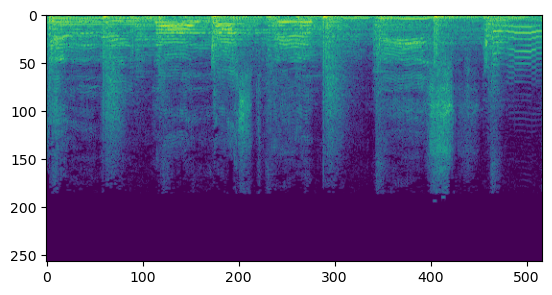

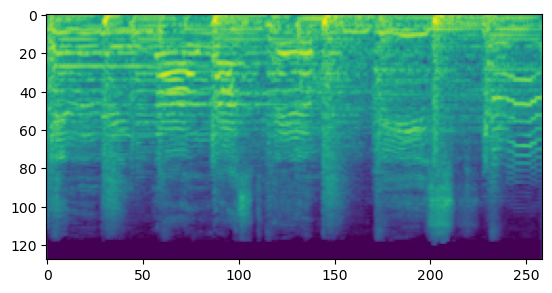

In [208]:
song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-2.wav")

spec = get_spec(center_clip(get_song(song_path)))
plot.figure()
plot.imshow(spec)
spec = get_mag(center_clip(get_song(song_path)))
plot.figure()
plot.imshow(spec)

## Metrics

In [209]:
def AccuracyMulti(tresh=0.5):
    def acc(x, y):
        return 1 - (((x > tresh).float() - y).abs()).float().mean()
    return acc
AccuracyMulti()(torch.tensor([[0.1, 0.9, 0.4], [0.2, 0.2, 0.6]]), torch.tensor([[1, 1, 0], [0, 0, 1]]))

tensor(0.8333)

## Building the model

In [210]:
get_song_tfms = [ToSong(), RandomClip(), CenterClip()]
get_label_tfms = [get_label, MultiCategorize(), OneHotEncode()]
get_single_label_tfms = [get_single_label, Categorize()]

get_spec_tfms = [get_spec, PILImage.create]
get_mag_tfms = [get_mag, PILImage.create]

In [211]:
def get_subset(x, p=0.9):
    return [x[i] for i in RandomSplitter(p)(x)[0]]

In [212]:
class AddRandomSongs(ItemTransform):
    split_idx = 0
    def __init__(self, items, augm=[], num=1, perc=0.5):
        self.items = np.array(items)
        self.get_song_pipe = Pipeline(get_song_tfms)
        self.augm_pipe = Pipeline(augm)
        self.get_label_pipe = Pipeline(get_label_tfms)
        self.num = num
        self.perc = perc
    
    def get_random_songs(self, k):
        files = np.random.choice(self.items, k)
        self.augm_pipe.split_idx = 0
        self.get_song_pipe.split_idx = 0
        X = [self.augm_pipe([self.get_song_pipe(f)])[0] for f in files]
        Y = [self.get_label_pipe(f) for f in files]
        return X, Y
        
    def encodes(self, item):
        if np.random.rand() >= self.perc: return item
        x, y = item
        l = np.random.poisson(self.num)
        X, Y = self.get_random_songs(l)
        X.append(x)
        Y.append(y)
        x = sum(X)
        y = TensorMultiCategory([min(i, 1) for i in sum(Y)])
        return [x, y]

In [213]:
class PitchShift(ItemTransform):
    split_idx = 0
    def __init__(self, perc=0.5):
        self.perc=perc
        
    def encodes(self,item):
        if np.random.rand() >= self.perc: return item
        x = item[0]
        n_steps = np.random.rand()*10-5
        x = librosa.effects.pitch_shift(x,sr=sample_rate, n_steps=n_steps)
        return [x] + item[1:]

In [214]:
class GaussianNoise(ItemTransform):
    split_idx = 0
    def __init__(self, perc=0.5):
        self.perc=perc
        
    def encodes(self,item):
        if np.random.rand() >= self.perc: return item
        x = item[0]
        noise = np.random.randn(len(x))
        x = x + 0.005*noise
        return [x] + item[1:]

In [215]:
class RandomRotate(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(self.l*sample_rate)
        i = np.random.randint(-maxran, maxran+1)
        x = np.roll(x, i)
        return [x] + item[1:]

In [216]:
class RandomEdgeSilence(ItemTransform):
    split_idx = 0
    def __init__(self, l=1):
        self.l = l
    def encodes(self, item):
        x = item[0]
        maxran = int(sample_rate*self.l)
        i = np.random.randint(-maxran, maxran+1)
        if i < 0: x[i:] = 0
        else: x[:i] = 0
        return [x] + item[1:]

In [217]:
class RandomAmp(ItemTransform):
    split_idx = 0
    def __init__(self, rng=[0.6,2]):
        self.rng = rng
    def encodes(self, item):
        x = item[0]
        x = x * np.random.uniform(self.rng[0], self.rng[1])
        return [x] + item[1:]

In [218]:
class ToSpec(ItemTransform):
    def __init__(self, tfms):
        self.pipe = Pipeline(tfms)
    def encodes(self, item):
        x = item[0]
        return [self.pipe(x)] + item[1:]

In [219]:
class ShowSong(ItemTransform):
    split_idx = 0
    def __init__(self, k=10):
        self.cnt = 0
        self.k = k
    def encodes(self, item):
        x, y = item
        if self.cnt < self.k + 1:
            if 0 < self.cnt:
                display(y)
                display(Audio(data=x, rate=sample_rate))
            self.cnt += 1
        return item

In [220]:
def get_dataset(items, splitter=RandomSplitter()):
    splits = splitter(items)
    return Datasets(items, [get_song_tfms, get_label_tfms], splits=splits)

In [221]:
irmas_splitter = FuncSplitter(lambda x: is_IRMAS_test(x))
irmas_splitter(get_song_files(grand_path))

((#7341) [2238,2239,2240,2241,2242,2243,2244,2245,2246,2247...],
 (#2238) [0,1,2,3,4,5,6,7,8,9...])

In [222]:
def change_shape(x):
    return np.reshape(x, (len(x), 1))

class ChangeShape(ItemTransform):
    def encodes(self, item):
        x = item[0]
        return [change_shape(x)] + item[1:]

In [171]:
change_shape(center_clip(get_song(items[0])))

array([[-0.12794495],
       [-0.13240051],
       [-0.13409424],
       ...,
       [ 0.00891113],
       [ 0.00820923],
       [ 0.00465393]], dtype=float32)

In [147]:
get_spec(get_song(items[0]))

array([[-39.28894 , -42.750504, -56.611847, ..., -63.918053, -34.9468  ,
        -32.066704],
       [-38.671124, -45.02373 , -49.301254, ..., -28.034174, -30.650875,
        -22.384354],
       [-38.737015, -47.10281 , -45.709946, ..., -16.234613, -19.222824,
        -16.525507],
       ...,
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -77.66934 ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -77.72929 ],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -77.91138 ]], dtype=float32)

In [134]:
get_song(items[0]).shape

(882000,)

In [183]:
items = get_song_files(grand_path)
train_dset = get_dataset(items, irmas_splitter)
augm_items = get_song_files(train_path) # [train_dset.items[i] for i in train_dset.splits[0]]

augm = [
    RandomRotate(l=1.5),
    RandomEdgeSilence(l=1),
    PitchShift(perc=0.5),
    GaussianNoise(perc=0.6),
    RandomAmp(rng=[0.8,1.2])
]
after_augm = [
    AddRandomSongs(augm_items, augm=augm, num=2.5),
    ShowSong(3),
#     ChangeShape(),
    ToSpec(get_spec_tfms),
    Resize((256, 156), method=ResizeMethod.Squish),
]

def get_dataloader(ds, augm=augm, after_augm=after_augm):
    after_item = augm + after_augm + [ToTensor(), IntToFloatTensor()]
    return ds.dataloaders(bs=64, after_item=after_item, shuffle=True)

TensorMultiCategory([0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.])

TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

TensorMultiCategory([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

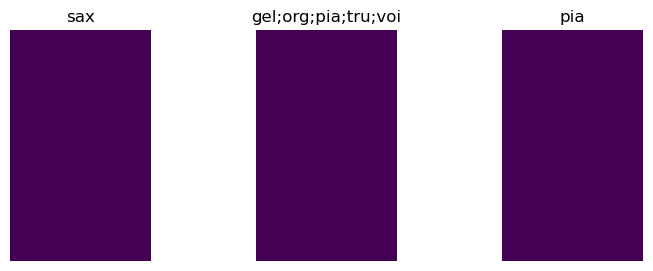

In [184]:
dls = get_dataloader(train_dset)
dls.show_batch(max_n=3)

In [185]:
print(len(dls.train.dataset))
print(len(dls.valid.dataset))
print(dls.vocab)
print(len(dls.vocab))

7341
2238
['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']
11


In [191]:
# learn = vision_learner(dls, lambda **args: learn_backup.model, metrics=AccuracyMulti(tresh=0.8)) 
learn = vision_learner(dls, resnet18, pretrained=True) #, metrics=AccuracyMulti(tresh=0.8))
# valid 
# no valid 0.878

/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [187]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,acc,time
0,0.781949,0.442999,0.851125,02:19


epoch,train_loss,valid_loss,acc,time
0,0.508215,0.384117,0.860590,02:26
1,0.446415,0.378075,0.865505,02:27
2,0.415693,0.342985,0.870948,02:24
3,0.401005,0.346475,0.869973,02:27


In [192]:
learn.export('laim_model.pkl')

In [64]:
# interp = Interpretation.from_learner(learn)

In [65]:
# interp.p lot_top_losses(10)

In [66]:
# _, idxs = interp.top_losses(3)

# for pat in np.array(dls.valid_ds.items)[idxs]:
#     print(pat)
#     print("Target:", get_label(pat))
#     print("Preds")
#     display(Audio(data=get_song(pat), rate=sample_rate))
    

## Track GPU usage

In [67]:
torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, 1, 0)

In [68]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1070'

In [69]:
import gc
def report_gpu():
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    gc.collect()
    torch.cuda.empty_cache()

In [70]:
report_gpu()

Memory Usage:
Allocated: 0.3 GB
Cached:    1.8 GB


## Test on Validation data

In [71]:
# for i in range(2):
#     test_items = get_song_files(test_path)
#     tdset = dls.test_dl(test_items, with_labels=True)
#     print(learn.validate(dl=tdset))

In [72]:
# tdset = dls.test_dl(test_items, with_labels=False)
# learn.get_preds(dl=tdset)

In [73]:
# song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-1.wav")
# song = center_clip(get_song(song_path))
# learn.predict(song)[1]

In [74]:
# def get_preds(learn, song, step=sample_rate):
#     res = np.array([0]*len(learn.dls.vocab))
#     rang = range(0, len(song)-sample_rate*3, step)
#     for i in rang:
#         short = song[i:i+sample_rate*3]
#         with io.capture_output() as captured:
#             res = res + L(learn.predict(short)[1].storage())
#     preds = []
#     for i, inst in enumerate(learn.dls.vocab):
#         if res[i] > len(rang) * 0.2:
#             preds.append(inst)
#     return preds

# song_path = Path("../Dataset/Dataset/IRMAS_Validation_Data/(02) dont kill the whale-3.wav")
# song = get_song(song_path)
# preds = get_preds(learn, song)
# print(preds)

In [75]:
# # Paralelize this!!!!
# def validate(learn):
#     mistakes = dict((v, 0) for v in learn.dls.vocab)
#     test_files = get_song_files(test_path)
#     print("0%", end="")
#     for i, file in enumerate(test_files):
#         song = get_song(file)
#         target_label = set(get_label(file))
#         pred_label = set(get_preds(learn, song))
#         false_label = target_label.symmetric_difference(pred_label)
#         for m in false_label:
#             mistakes[m] += 1
#         print(f"\r{int(100 * i / len(test_files))}%", end="")
#     print()
#     for m in mistakes:
#         mistakes[m] /= len(test_files)
#     return mistakes

In [76]:
# Datasets(items, [get_song_tfms, ], split_idx=1)

In [77]:
# preds = tensor([[0., 0., 0.,   0., 0., 0.],
#          [0., 0., 0.,   0., 0., 1.],
#          [0., 0., 0.,   0., 0., 1.],
#          [0., 0., 1.,   0., 0., 0.],
#          [0., 0., 1.,   0., 0., 0.],
#          [0., 0., 0.,   0., 0., 0.]])
# learn.dls.vocab[sum(preds[[1,4]]) >= 1]

In [78]:
# learn.get_preds(dl=tdset, with_targs=True)[0]

In [79]:
def get_sl_windows(song, step=sample_rate):
    ran = range(0, len(song)-sample_rate-step, step)
    if len(ran) == 0: yield extend_to_3sr([0])
    for i in ran: 
        yield extend_to_3sr(song[i:i+sample_rate*3])

In [71]:
# learn.predict(get_song(items[0]))

((#1) ['gel'],
 TensorBase([False, False, False, False,  True, False, False, False, False,
             False, False]),
 TensorBase([0.1821, 0.1206, 0.1315, 0.0640, 0.5114, 0.1878, 0.1217, 0.0904,
             0.1008, 0.1748, 0.2502]))

In [53]:
# valid_dls = learn.dls.new_empty()
# valid_dls.tfms = L([Pipeline([lambda o: o]), valid_dls.tfms[1]])
# valid_dl = learn.dls.test_dl(items, with_labels=False)
# learn.get_preds(dl=valid_dl)

In [75]:
# def validate(learn, items):
#     test_items = []
#     song_idxs = {}
#     print(f"Original number of items: {len(items)}")
#     for i, file in enumerate(items):
#         song_idxs[file] = []
#         for sl in get_sl_windows(get_song(file)):
#             test_items.append(sl)
#             song_idxs[file].append(len(test_items)-1)
#     print(f"Created dataset with {len(test_items)} items")
#     valid_dl = learn.dls.test_dl(test_items, with_labels=False)
#     preds = learn.get_preds(dl=valid_dl)[0]
    
#     mistakes = dict((v, 0) for v in learn.dls.vocab)
#     for file in items:
#         pred_label = set(learn.dls.vocab[sum(preds[song_idxs[file]]) > len(song_idxs[file]) * 0.3])
#         target_label = set(get_label(file))
#         for m in target_label.symmetric_difference(pred_label):
#             mistakes[m] += 1
#     report_gpu()
#     return mistakes
    

In [72]:
# files = get_song_files(test_path)
# for j, file in enumerate(files):
#     ran = get_sl_windows(get_song(file))
#     print(f"{j} / {len(files)} - {file} / ", end = " ")
#     for i, sl in enumerate(get_sl_windows(get_song(file))):
#         print(i, end=" ")
#         with io.capture_output() as captured:
#             learn.predict(sl)
#     print()

0 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-1.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-11.wav /  0 1 2 3 4 5 6 7 8 9 10 
2 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
3 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
4 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-17.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
5 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-19.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
6 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-20.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
7 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/0050_10CC___I_M_NOT_IN_LOVE-21.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 

66 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/01. The Best Of Wayne Shorter - The Blue Note Years - [Speak No Evil]-1.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
67 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/01. The Best Of Wayne Shorter - The Blue Note Years - [Speak No Evil]-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
68 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/01. The Best Of Wayne Shorter - The Blue Note Years - [Speak No Evil]-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
69 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/01. The Best Of Wayne Shorter - The Blue Note Years - [Speak No Evil]-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
70 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/01. The Best Of Wayne Shorter - The Blue Note Years - [Speak No Evil]-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
71 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/01. The Best Of Wayne Shorter - The Blue Note Years - [Speak No Evil]-15.wav /  0 1 2 3 4 5 6 

123 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - And The Body Will Die-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
124 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - And The Body Will Die-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
125 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - Bo-Do-1.wav /  0 1 2 3 4 5 6 7 8 
126 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - Bo-Do-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
127 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - Bo-Do-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
128 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - Bo-Do-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
129 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - Bo-Do-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
130 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - Bo-Do-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
131 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 - Bo-Do-17.wav /  0 1 2 3 4 5 6 7 

192 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Stardust-2.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
193 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Stardust-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
194 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Stardust-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
195 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Stardust-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
196 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Stardust-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
197 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Stardust-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
198 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Walkin-2.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
199 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02 Walkin-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
200 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/02-the_mars_volta-the_widow-jrp-1.wav /  0 1 2 3 4 5 6 7 8 

260 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03 -  robert fripp, brian eno - evening star-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
261 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03 -  robert fripp, brian eno - evening star-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
262 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03 -  robert fripp, brian eno - evening star-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
263 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03 -  robert fripp, brian eno - evening star-14.wav /  0 1 2 3 4 5 6 7 
264 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03 -  robert fripp, brian eno - evening star-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
265 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03 -  robert fripp, brian eno - evening star-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
266 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03 -  robert fripp, brian eno - evening star-18.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15

322 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-I'll Be OK-2.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
323 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-I'll Be OK-4.wav /  0 1 2 3 4 5 6 7 8 
324 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-I'll Be OK-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
325 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-I'll Be OK-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
326 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-I'll Be OK-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
327 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-I'll Be OK-9.wav /  0 1 2 3 4 5 6 7 8 9 
328 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-the_beatles-lucy_in_the_sky_with_diamonds-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
329 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-the_beatles-lucy_in_the_sky_with_diamonds-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
330 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/03-the_beatles-lucy_in_the_s

391 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
392 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
393 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
394 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
395 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-18.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
396 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-19.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
397 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-21.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
398 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-23.wav /  0 1 2 3 4 5 6 7 8 9 10 11 
399 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/04 The Czar-24.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 
400 / 2238

460 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Bobbi Humphrey - You Are The Sunshine of My Life-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
461 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Bobbi Humphrey - You Are The Sunshine of My Life-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
462 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Bobbi Humphrey - You Are The Sunshine of My Life-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
463 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Gidon Kremer - Violin Concerto No. 5 In A Major, K. 219- Adagio - Gidon Kremer-1.wav /  0 1 2 3 
464 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Gidon Kremer - Violin Concerto No. 5 In A Major, K. 219- Adagio - Gidon Kremer-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
465 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Gidon Kremer - Violin Concerto No. 5 In A Major, K. 219- Adagio - Gidon Kremer-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
466 / 22

506 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Sonata in A minor, Op. post. 143 D.784 - I. Allegro giusto-23.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
507 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Sonata in A minor, Op. post. 143 D.784 - I. Allegro giusto-24.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
508 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Sonata in A minor, Op. post. 143 D.784 - I. Allegro giusto-25.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
509 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Sonata in A minor, Op. post. 143 D.784 - I. Allegro giusto-26.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
510 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Sonata in A minor, Op. post. 143 D.784 - I. Allegro giusto-27.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
511 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 - Sonata in A minor, Op. post. 143 D.784 - I. Allegro giusto-28.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17

559 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 Mendelssohn - Piano Concerto No. 2 - II. Adagio (molto sostenuto)-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
560 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05 Mendelssohn - Piano Concerto No. 2 - II. Adagio (molto sostenuto)-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
561 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05-antonio_orozco-hoy_todo_va_al_reves_(con_toteking)-nyd-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
562 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05-antonio_orozco-hoy_todo_va_al_reves_(con_toteking)-nyd-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
563 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05-antonio_orozco-hoy_todo_va_al_reves_(con_toteking)-nyd-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
564 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/05-antonio_orozco-hoy_todo_va_al_reves_(con_toteking)-nyd-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
565 / 2238 - .

620 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - Lali Puna - Faking the Books-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
621 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-1.wav /  0 1 2 3 4 5 6 7 
622 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-10.wav /  0 1 2 3 4 5 6 7 
623 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-11.wav /  0 1 2 3 4 5 6 7 
624 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
625 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
626 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
627 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-16.wav /  0 1 2 3 4 5 6 
628 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-17.wav /  0 1 2 3 4 5 6 7 
629 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06 - New Noise-18.wav /  0 

693 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
694 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
695 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-17.wav /  0 1 2 3 
696 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-18.wav /  0 1 2 3 
697 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-19.wav /  0 1 2 3 
698 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-20.wav /  0 1 2 3 
699 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-21.wav /  0 1 2 3 
700 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-22.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
701 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-23.wav /  0 1 2 3 
702 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-3.wav /  0 1 2 3 4 5 6 7 8 
703 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/06-Confirmation-4.wa

761 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/07. Buddy DeFranco & Tommy Gumina - Scrapple from the Apple-15.wav /  0 1 2 3 4 5 6 7 8 9 10 
762 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/07. Buddy DeFranco & Tommy Gumina - Scrapple from the Apple-17.wav /  0 1 2 3 4 
763 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/07. Buddy DeFranco & Tommy Gumina - Scrapple from the Apple-2.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
764 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/07. Buddy DeFranco & Tommy Gumina - Scrapple from the Apple-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
765 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/07. Buddy DeFranco & Tommy Gumina - Scrapple from the Apple-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
766 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/07. Buddy DeFranco & Tommy Gumina - Scrapple from the Apple-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
767 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/07. Buddy DeFranco & Tommy Gumina

827 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-14.wav /  0 1 2 3 4 5 6 
828 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
829 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
830 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-18.wav /  0 1 2 3 4 5 
831 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-19.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
832 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-20.wav /  0 1 2 3 4 
833 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-21.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
834 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/08-Concerto in A major, K 219 -2- Adagio-22.wav /  0 1 

892 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/10 - Johann Sebastian Bach - English Suite No. 3 in G major, BWV 808 (Andràs Schiff) (1)-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
893 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/10 - Johann Sebastian Bach - English Suite No. 3 in G major, BWV 808 (Andràs Schiff) (1)-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
894 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/10 - Johann Sebastian Bach - English Suite No. 3 in G major, BWV 808 (Andràs Schiff) (1)-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
895 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/10 - Johann Sebastian Bach - English Suite No. 3 in G major, BWV 808 (Andràs Schiff) (1)-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
896 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/10 - Johann Sebastian Bach - English Suite No. 3 in G major, BWV 808 (Andràs Schiff) (1)-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
897 / 2238 - ../Dataset/Dataset/IRMAS_Te

953 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/109-jimmy_mcgriff-jumpin_the_blues-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
954 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/109-jimmy_mcgriff-jumpin_the_blues-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
955 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/109-jimmy_mcgriff-jumpin_the_blues-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
956 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/109-jimmy_mcgriff-jumpin_the_blues-2.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
957 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/109-jimmy_mcgriff-jumpin_the_blues-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
958 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/109-jimmy_mcgriff-jumpin_the_blues-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
959 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/109-jimmy_mcgriff-jumpin_the_blues-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
960 / 2238 - ../Dataset/Dataset/IRMAS_

1018 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/14-god is an astronaut - all is violent, all is bright-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1019 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/14-god is an astronaut - all is violent, all is bright-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1020 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/14-god is an astronaut - all is violent, all is bright-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1021 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/14-god is an astronaut - all is violent, all is bright-3.wav /  0 1 2 3 4 5 
1022 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/14-god is an astronaut - all is violent, all is bright-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1023 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/14-god is an astronaut - all is violent, all is bright-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1024 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/14-god is an astronaut - all is 

1078 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/1992 - Blind Guardian - Somewhere Far Beyond - The Bard's Song (In The Forest)-2.wav /  0 1 2 3 4 5 
1079 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/1992 - Blind Guardian - Somewhere Far Beyond - The Bard's Song (In The Forest)-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
1080 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/1992 - Blind Guardian - Somewhere Far Beyond - The Bard's Song (In The Forest)-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1081 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/1992 - Blind Guardian - Somewhere Far Beyond - The Bard's Song (In The Forest)-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1082 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/1992 - Blind Guardian - Somewhere Far Beyond - The Bard's Song (In The Forest)-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1083 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/1992 - Blind Guardian - Somewhere Far Beyond - The Bard's Song (In The Forest)-9.wav /  

1130 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/2004 - Tierra Santa - Apocalipsis - Neron-5.wav /  0 1 2 3 4 
1131 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/2004 - Tierra Santa - Apocalipsis - Neron-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1132 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/2004 - Tierra Santa - Apocalipsis - Neron-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1133 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/2004 - Tierra Santa - Apocalipsis - Neron-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1134 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/207-Dave Douglas-The Jones-1.wav /  0 1 2 3 
1135 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/207-Dave Douglas-The Jones-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1136 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/207-Dave Douglas-The Jones-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1137 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/207-Dave Douglas-The Jones-14.wav /  0 1 2 3 4 5 

1193 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/AC DC (Back In Black) -01- Hells Bells-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
1194 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/AC DC (Back In Black) -01- Hells Bells-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1195 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/AC DC (Back In Black) -01- Hells Bells-6.wav /  0 1 2 3 4 5 6 7 8 9 10 
1196 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/AC DC (Back In Black) -01- Hells Bells-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1197 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/AC DC (Back In Black) -01- Hells Bells-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1198 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/agw_-_03_-_st. elmo's fire-1.wav /  0 1 2 3 4 5 6 7 
1199 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/agw_-_03_-_st. elmo's fire-10.wav /  0 1 2 3 4 5 6 7 8 9 
1200 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/agw_-_03_-_st. elmo's fire-11.wav /  0 1 2 3 4 5 6 7 8 


1260 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/arvo p_rt - alina - 01 - spiegel im spiegel-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1261 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/arvo p_rt - alina - 01 - spiegel im spiegel-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1262 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/arvo p_rt - alina - 01 - spiegel im spiegel-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1263 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/arvo p_rt - alina - 01 - spiegel im spiegel-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1264 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/arvo p_rt - alina - 01 - spiegel im spiegel-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1265 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/arvo p_rt - alina - 01 - spiegel im spiegel-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1266 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/arvo p_rt - alina - 01 - spiegel im spiegel-16.wav /  0 1 2 3 4

1322 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Bobby Sox Blues-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 
1323 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Bobby Sox Blues-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1324 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/brian eno - apollo- atmospheres & soundtracks - 01 - under stars-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
1325 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/brian eno - apollo- atmospheres & soundtracks - 01 - under stars-11.wav /  0 1 2 3 4 5 6 7 8 
1326 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/brian eno - apollo- atmospheres & soundtracks - 01 - under stars-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 
1327 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/brian eno - apollo- atmospheres & soundtracks - 01 - under stars-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1328 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/brian eno - apollo- atmospheres & soundtracks - 01 - under stars-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 1

1380 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Debussy, Sonata for Cello & Piano - 1 Prologue-3.wav /  0 1 2 3 4 5 6 
1381 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Debussy, Sonata for Cello & Piano - 1 Prologue-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1382 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Debussy, Sonata for Cello & Piano - 1 Prologue-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1383 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Debussy, Sonata for Cello & Piano - 1 Prologue-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1384 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Debussy, Sonata for Cello & Piano - 1 Prologue-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1385 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Debussy, Sonata for Cello & Piano - 1 Prologue-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1386 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Debussy, Sonata for Cello & Piano - 1 Prologue-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11

1442 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Depeche Mode - Personal Jesus-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 
1443 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Depeche Mode - Personal Jesus-9.wav /  0 1 2 3 
1444 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Doc Watson - Doc Watson - Deep River Blues-1.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1445 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Doc Watson - Doc Watson - Deep River Blues-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
1446 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Doc Watson - Doc Watson - Deep River Blues-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1447 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Doc Watson - Doc Watson - Deep River Blues-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1448 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Doc Watson - Doc Watson - Deep River Blues-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1449 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Doc Watso

1499 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1500 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 
1501 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-15.wav /  0 1 2 3 4 
1502 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1503 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-2.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
1504 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1505 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1506 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Faith No More - Stripsearch-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1507 / 2238 - .

1565 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Gnawa Diffussion - Bleu blanc gyrophare-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
1566 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Gnawa Diffussion - Bleu blanc gyrophare-8.wav /  0 1 2 3 4 5 6 
1567 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Gnawa Diffussion - Bleu blanc gyrophare-9.wav /  0 1 2 3 4 5 
1568 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/gyorgy ligeti- atmospheres-1.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1569 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/gyorgy ligeti- atmospheres-10.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1570 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/gyorgy ligeti- atmospheres-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1571 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/gyorgy ligeti- atmospheres-14.wav /  0 1 2 3 4 5 6 7 8 9 10 
1572 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/gyorgy ligeti- atmospheres-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1573 / 2238 - .

1629 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/James Galway - 'Pennywhistle Jig'-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1630 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/James Galway - 'Pennywhistle Jig'-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
1631 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Jelly Roll Morton - Honky Tonk Blues-1.wav /  0 1 2 3 4 5 6 7 
1632 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Jelly Roll Morton - Honky Tonk Blues-10.wav /  0 1 2 3 
1633 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Jelly Roll Morton - Honky Tonk Blues-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1634 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Jelly Roll Morton - Honky Tonk Blues-12.wav /  0 1 2 3 
1635 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Jelly Roll Morton - Honky Tonk Blues-13.wav /  0 1 2 3 4 5 
1636 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Jelly Roll Morton - Honky Tonk Blues-14.wav /  0 1 2 3 4 
1637 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Jell

1693 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/kate bush - aerial - cd 2 - a sky of honey - 08 - nocturn-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1694 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/kate bush - aerial - cd 2 - a sky of honey - 08 - nocturn-18.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1695 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/kate bush - aerial - cd 2 - a sky of honey - 08 - nocturn-20.wav /  0 1 2 3 4 5 6 7 8 
1696 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/kate bush - aerial - cd 2 - a sky of honey - 08 - nocturn-21.wav /  0 1 2 3 4 5 6 
1697 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/kate bush - aerial - cd 2 - a sky of honey - 08 - nocturn-22.wav /  0 1 2 3 4 5 6 
1698 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/kate bush - aerial - cd 2 - a sky of honey - 08 - nocturn-23.wav /  0 1 2 3 4 5 6 
1699 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/kate bush - aerial - cd 2 - a sky of honey - 08 - nocturn-24.wav /  0 1 2 3 4 5 6 7 
1700 / 223

1751 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith jarrett - arbour zena - 01 - runes-46.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1752 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith jarrett - arbour zena - 01 - runes-48.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1753 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith jarrett - arbour zena - 01 - runes-49.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1754 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith jarrett - arbour zena - 01 - runes-5.wav /  0 1 2 3 
1755 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith jarrett - arbour zena - 01 - runes-50.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1756 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith jarrett - arbour zena - 01 - runes-52.wav /  0 1 2 3 4 5 
1757 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith jarrett - arbour zena - 01 - runes-53.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1758 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/keith

1814 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1815 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-17.wav /  0 1 2 3 4 5 
1816 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-18.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1817 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-20.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1818 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-21.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1819 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-23.wav /  0 1 2 3 4 
1820 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-25.wav /  0 1 2 3 4 5 6 7 
1821 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Metallica - Nothing Else Matters-26.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17

1872 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Nusrat Fateh Ali Khan - Mustt mustt-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1873 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Nusrat Fateh Ali Khan - Mustt mustt-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1874 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Pantera - Floods-1.wav /  0 1 2 3 4 5 6 7 8 9 10 
1875 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Pantera - Floods-10.wav /  0 1 2 3 4 5 6 
1876 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Pantera - Floods-11.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1877 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Pantera - Floods-13.wav /  0 1 2 3 4 5 6 
1878 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Pantera - Floods-14.wav /  0 1 2 3 
1879 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Pantera - Floods-16.wav /  0 1 2 3 
1880 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Pantera - Floods-18.wav /  0 1 2 3 4 5 6 7 8 9 10 
1881 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/P

1933 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/propaganda - dr. mabuse ('13th life' mix)-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 
1934 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/propaganda - dr. mabuse ('13th life' mix)-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 
1935 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Queen of the Stone Age - 08 - Go With the Flow-1.wav /  0 1 2 3 4 5 6 7 8 9 
1936 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Queen of the Stone Age - 08 - Go With the Flow-10.wav /  0 1 2 3 4 5 
1937 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Queen of the Stone Age - 08 - Go With the Flow-11.wav /  0 1 2 3 4 5 
1938 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Queen of the Stone Age - 08 - Go With the Flow-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
1939 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Queen of the Stone Age - 08 - Go With the Flow-13.wav /  0 1 2 3 
1940 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Queen of the Stone Age - 08 - Go With the Flow-14.wav /

1994 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/satie - 1ere gymnopedie. lent et douloureux-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1995 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/satie - 1ere gymnopedie. lent et douloureux-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1996 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Schoenberg - Nacht-1.wav /  0 1 2 3 4 5 
1997 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Schoenberg - Nacht-2.wav /  0 1 2 3 4 5 6 7 8 
1998 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Schoenberg - Nacht-3.wav /  0 1 2 3 4 5 6 7 
1999 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Schoenberg - Nacht-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 
2000 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Schoenberg - Nacht-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2001 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Schoenberg - Nacht-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2002 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Schoenberg - Nacht-8.wa

2046 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Sonny Rollins - 05 - Sonnysphere-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2047 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Sonny Rollins - 05 - Sonnysphere-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2048 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Sonny Rollins - 05 - Sonnysphere-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2049 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Sonny Rollins - 05 - Sonnysphere-7.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2050 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Sonny Rollins - 05 - Sonnysphere-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2051 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Sonny Rollins - 05 - Sonnysphere-9.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2052 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/talk talk - spirit of eden - 05 - i believe in you-1.wav /  0 1 2 3 4 
2053 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/talk talk - spi

2111 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Police - 01 - Synchronicity I-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
2112 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Police - 01 - Synchronicity I-4.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
2113 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Police - 01 - Synchronicity I-5.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
2114 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Police - 01 - Synchronicity I-6.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2115 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Police - 01 - Synchronicity I-7.wav /  0 1 2 3 4 5 6 7 
2116 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Police - 01 - Synchronicity I-8.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2117 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Shamen - Move Any Mountain-11.wav /  0 1 2 3 4 
2118 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/The Shamen - Move Any Mountain-12.wav /  0 1 2 3 4 5 6 7 8 9 10 11 
2119 / 2238 - ../Dataset/Dataset/

2181 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-10.wav /  0 1 2 3 4 5 
2182 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-11.wav /  0 1 2 3 4 5 
2183 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-12.wav /  0 1 2 3 4 
2184 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-13.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 
2185 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-14.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 
2186 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-15.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 
2187 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-16.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
2188 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-18.wav /  0 1 2 3 4 5 
2189 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-2.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 13 
2190 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-3.wav /  0 1 2 3 4 5 6 7 8 9 10 11 12 
2191 / 2238 - ../Dataset/Dataset/IRMAS_Test_Data/Track 01-4.wav /

In [76]:
# def validate_with_split(learn, items, size=200):
#     mistakes = dict((v, 0) for v in learn.dls.vocab)
#     for i in range(0, len(items), size):
#          for m, n in validate(learn, items[i: i+size]).items():
#                 mistakes[m] += n
#     for m in mistakes:
#         mistakes[m] /= len(items)
#     return mistakes
            
        
    

In [ ]:
# validate_with_split(learn, get_song_files(test_path), size=500)

Original number of items: 500
Created dataset with 8049 items


Memory Usage:
Allocated: 0.4 GB
Cached:    1.8 GB
Original number of items: 500


In [82]:
from datetime import datetime

def train(arch=resnet18, spec_tfms=get_spec_tfms, info= "...", tresh=0.8, epochs=16, pretrained=True):
    print("Setup:")
    print(info)
    print(arch, spec_tfms)
    augm = [
        RandomRotate(l=1.5),
        RandomEdgeSilence(l=1),
        PitchShift(perc=0.5),
        GaussianNoise(perc=0.6),
        RandomAmp(rng=[0.8,1.2])
    ]
    after_augm = [
        AddRandomSongs(augm_items, augm=augm, num=2.5),
        ToSpec(get_spec_tfms),
        Resize((256, 156), method=ResizeMethod.Squish),
    ]
    dls = get_dataloader(train_dset, augm=augm, after_augm=after_augm)
    learn = vision_learner(dls, arch, pretrained=pretrained, metrics=AccuracyMulti(tresh=tresh))
    learn.fine_tune(epochs)
    
    tim = datetime.now().strftime("%H_%M_%S")
    print(learn.export(f'{tim}_model'))
    report_gpu()

In [81]:
# avg all zeros 0.844467
# train(resnet18, tfms=get_spec_tfms, info="Resnet18 - with spectogram") # 0.844468
# train(resnet18, spec_tfms=get_mag_tfms, info="Resnet18 - with magspectogram", epochs=1) # 0.861833
train(squeezenet1_0, info="squeezenet1_0", epochs=16) # 862023
# train(densenet121, info="densenet121", epochs=16) # 0.844468 NOT WORKING???
train(vgg16_bn, info="vgg16_bn", epochs=16) # 0.871576
train(alexnet, info="alexnet", epochs=16) # 0.858227

Setup:
squeezenet1_0
<function squeezenet1_0 at 0x7f623ae1ce50> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,0.755899,0.674020,0.826834,02:06


epoch,train_loss,valid_loss,acc,time
0,0.527592,0.448445,0.846251,02:08
1,0.488709,0.802972,0.843123,02:07
2,0.476786,1.326348,0.850394,02:08
3,0.458942,2.979198,0.841336,02:10
4,0.442922,0.408169,0.856853,02:10
5,0.432857,0.417219,0.865667,02:06
6,0.416490,0.417862,0.857625,02:07
7,0.415891,0.432310,0.863677,02:08
8,0.410581,0.384453,0.859452,02:13
9,0.400298,0.389415,0.863393,02:11


models/16_51_48_model.pth
Memory Usage:
Allocated: 0.3 GB
Cached:    2.5 GB
Setup:
densenet121
<function densenet121 at 0x7f623af8d630> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,nan,nan,0.846210,02:25


epoch,train_loss,valid_loss,acc,time
0,nan,nan,0.846210,02:26
1,nan,nan,0.846210,02:26
2,nan,nan,0.846210,02:23
3,nan,nan,0.846210,02:23
4,nan,nan,0.846210,02:23
5,nan,nan,0.846210,02:23
6,nan,nan,0.846210,02:27
7,nan,nan,0.846210,02:24
8,nan,nan,0.846210,02:25
9,nan,nan,0.846210,02:26


models/17_33_03_model.pth
Memory Usage:
Allocated: 0.4 GB
Cached:    7.3 GB
Setup:
vgg16_bn
<function vgg16_bn at 0x7f623ae1e3b0> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,0.764368,0.419789,0.855106,04:02


epoch,train_loss,valid_loss,acc,time
0,0.520756,0.370748,0.866520,04:20
1,0.466925,0.371876,0.868876,04:21
2,0.424415,0.340800,0.876066,04:23
3,0.399789,0.351615,0.878869,04:22
4,0.378100,0.324880,0.889268,04:21
5,0.359006,0.314657,0.890284,04:20
6,0.339602,0.317148,0.892396,04:22
7,0.334285,0.288167,0.897595,04:22
8,0.324094,0.309500,0.895483,04:23
9,0.321131,0.309102,0.891015,04:21


models/18_48_28_model.pth
Memory Usage:
Allocated: 0.6 GB
Cached:    7.0 GB
Setup:
alexnet
<function alexnet at 0x7f623af28dc0> [<function get_spec at 0x7f623aaaf0a0>, <bound method PILBase.create of <class 'fastai.vision.core.PILImage'>>]


/home/rangoiv/mambaforge/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,acc,time
0,0.758053,0.461932,0.845113,02:11


epoch,train_loss,valid_loss,acc,time
0,0.534013,0.427251,0.851531,02:16
1,0.489807,0.411028,0.852912,02:08
2,0.467840,0.386797,0.855675,02:10
3,0.450230,0.406632,0.859412,02:10
4,0.435331,0.418562,0.853644,02:15
5,0.416431,0.363115,0.864124,02:13
6,0.412728,0.364101,0.860224,02:15
7,0.403153,0.365975,0.867739,02:18
8,0.394308,0.346459,0.867779,02:13
9,0.393195,0.361189,0.866033,02:13


models/19_26_22_model.pth
Memory Usage:
Allocated: 0.5 GB
Cached:    2.5 GB


## Gradient Accumulation

In [87]:
report_gpu()

Memory Usage:
Allocated: 0.2 GB
Cached:    0.6 GB


In [ ]:
# def train2(arch, accum=1, finetune=True, epochs=12, bs=64):
#     _dls = DataBlock(
#         blocks = [ImageBlock(), MultiCategoryBlock],
#         get_items = get_song_files,
#         splitter = RandomSplitter(),
#         get_x = get_magspec,
#         get_y = get_label
#     ).dataloaders(path, bs=bs)
#     cbs = GradientAccumulation(64) if accum else []
#     learn = vision_learner(_dls, arch, metrics=acc, cbs=cbs).to_fp16()
#     if finetune:
#         learn.fine_tune(epochs, 0.01)
#         # return learn.tta(dl=dls.test_dl(tst_files))
#     else:
#         learn.unfreeze()
#         learn.fit_one_cycle(epochs, 0.01)